In [1]:
import sys
sys.path.append('./code')
sys.path.append('./data')

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from clustering import *

np.random.seed(12345)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.linewidth'] = 1.25

#modified from Kausik et al's code

In [2]:
nGenres=100
genres = pd.read_csv('data/Lastfm-ArtistTags2007/tags.txt', header=None)[0].values[:nGenres]
genres = pd.DataFrame([genre.split()[0] for genre in genres], 
             index = [' '.join(genre.split()[1:]) for genre in genres],
            columns = ['count'])
genres.head()
users = pd.read_csv("data/lastfm-dataset-1K/userid-profile.tsv", sep="\t")
users.head()
lastfm = pd.read_csv("data/lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv", sep="\t", 
           header=None, on_bad_lines='skip')
lastfm.columns = ['userid', 'timestamp', 'artistid', 'artistname', 'trackid', 'trackname']


In [3]:
nTopUsers=500 # may get reduced later
topusers = lastfm.groupby('userid').size().sort_values()[-nTopUsers:]
lastfm = lastfm[[user in topusers for user in lastfm['userid']]]
lastfm.timestamp = pd.to_datetime(lastfm['timestamp'])

In [4]:
tags = pd.read_table('data/Lastfm-ArtistTags2007/ArtistTags.dat', sep="<sep>", header=None, on_bad_lines='skip')
tags.columns = ['artistid', 'artistname', 'tagname', 'rawtagcount']
tags = tags[[tag in genres.index for tag in tags['tagname']]]
# there are multiple tags/genres assigned to each artist.
#  for simplicity, pick the tag/genre most associated with each artist
#  by ranking by raw tag count and picking the first
tags = tags[tags.groupby(['artistid', 'artistname'])['rawtagcount'].rank(method='first', ascending=False) <= 1]

/tmp/cemiles/31573678/ipykernel_1525091/2105939917.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tags = pd.read_table('data/Lastfm-ArtistTags2007/ArtistTags.dat', sep="<sep>", header=None, on_bad_lines='skip')


In [5]:
dataset = lastfm.merge(tags, on='artistid').sort_values(['userid', 'timestamp'])[['userid', 'timestamp', 'tagname']].reset_index()
# assigning numbers to genres. doing so by ranking genres by how popular they are
tagdict = dict(zip(genres.index.values, np.arange(len(genres))))
dataset['tagnum'] = dataset['tagname'].replace(tagdict)
# for some reason, gupta et al only consider the transitions that change genre
#  we do so here
keeps = (dataset.tagname != dataset.tagname.shift()) * (dataset.userid == dataset.userid.shift())
keeps[0] = True
dataset = dataset[keeps]

/opt/apps/anaconda/2022.05/lib/python3.9/site-packages/pandas/core/computation/expressions.py:214: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  warnings.warn(


In [6]:
playCounts = dataset.groupby('userid').size()

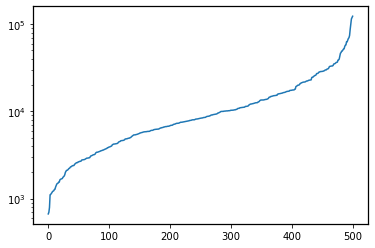

In [7]:
plt.plot(np.sort(playCounts))
plt.yscale('log')

In [8]:
horizon = 1000 # length of trajectories 
aboveThresh = playCounts.index[playCounts.values>horizon]

In [9]:
dataset=dataset[dataset.userid.isin(aboveThresh)]
topusers = dataset.groupby('userid').size().sort_values()

In [10]:
nStates = len(genres)
nActions = 1
K = len(topusers)
N = int(1*horizon) 
numTrajPerK = int(N/horizon)
nTraj = numTrajPerK * K

In [11]:

#shuffling dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset = dataset.sort_values(by='timestamp')    

states = np.array([dataset[dataset.userid == user].tagnum.values[:N] 
          for user in topusers.index.sort_values()])

nextstates = np.array([dataset[dataset.userid == user].tagnum.values[1:N+1] 
          for user in topusers.index.sort_values()])
onehots = np.array([np.eye(nStates)[dataset[dataset.userid == user].tagnum.values][:N] 
          for user in topusers.index.sort_values()])
onehotsp = np.array([np.eye(nStates)[dataset[dataset.userid == user].tagnum.values][1:N+1] 
          for user in topusers.index.sort_values()])

#splitting into trajectories of length horizon
states = np.array(np.split(states, numTrajPerK, axis=1)).transpose(1,0,2)
nextstates = np.array(np.split(nextstates, numTrajPerK, axis=1)).transpose(1,0,2)
onehots = np.array(np.split(onehots, numTrajPerK, axis=1)).transpose(1,0,2,3)
onehotsp = np.array(np.split(onehotsp, numTrajPerK, axis=1)).transpose(1,0,2,3)

print('shape of states before concat first axis:', states.shape)
print('shape of onehots before concat first axis:', onehots.shape)
#why concatenate? want 0,..,0,1...,1,...,9...,9
labels = np.concatenate([np.ones(numTrajPerK)*k for k in range(K)])
states = np.concatenate(states)
nextstates = np.concatenate(nextstates)
onehots = np.concatenate(onehots)
onehotsp = np.concatenate(onehotsp)
print('shape of states after concat first axis:', states.shape)
print('shape of onehots after concat first axis:', onehots.shape)

#shuffling
#inds = np.arange(len(labels)) # Kausik shuffles but we do not. Why temporally shuffle temporal data?
#np.random.shuffle(inds)
#labels = labels[inds]
#states = states[inds]
#onehots = onehots[inds]
#onehotsp = onehotsp[inds]

shape of states before concat first axis: (497, 1, 1000)
shape of onehots before concat first axis: (497, 1, 1000, 100)
shape of states after concat first axis: (497, 1000)
shape of onehots after concat first axis: (497, 1000, 100)


In [12]:
nEM = 5000
nClustMax=100

Xt=states
nStates=nGenres

zHat, muHat, qHat, pHat, steps, logL = doVEMmultiPar(Xt, nClustMax, nStates, nEM=nEM)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed: 42.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 42.4min finished


In [13]:
nSims=10000

def MC_counts(muHat,nTrajs, nSims):
    counts = np.zeros(nSims)
    for i in range(nSims):
        dirchsamp = np.random.dirichlet(muHat,1)
        rng = np.random.default_rng()
        labelsamp = rng.multinomial(nTrajs,dirchsamp,size=1)
        counts[i]= np.sum(labelsamp>0)
    return counts

N, nClusters = np.shape(zHat)    
mc_counts = MC_counts(muHat,N,nSims)


In [14]:
with open('temp/lastfm_clustusers.npy', 'wb') as f:
    np.save(f,mc_counts)
    np.save(f,muHat)
    np.save(f,zHat)
    np.save(f,states)


In [15]:
clustSums = np.sum(zHat,axis=0)
nonZeroClust = clustSums[clustSums>0]

In [16]:
np.sum(np.sum(zHat,axis=0)>0)

90

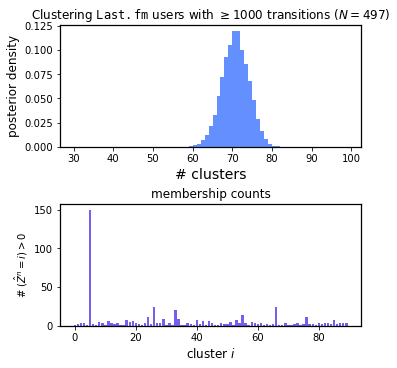

In [17]:
colors = np.array(['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000'])


fig, ax = plt.subplots(2,1,layout='constrained',figsize=(5,5))
ax[0].hist(mc_counts, bins=range(30,100),density=True,color=colors[0])
#ax.set_xticks([30, 35,  40, 45, 50, 55, 60])
ax[0].set_xlabel('# clusters',fontsize=14)
ax[0].set_ylabel('posterior density',fontsize=12)
ax[0].set_title("Clustering ${\\tt Last.fm}$ users with $\\geq 1000$ transitions ($N=497$)")


ax[1].bar(range(len(nonZeroClust)), nonZeroClust, color=colors[1])
ax[1].set_xlabel('cluster $i$',fontsize=12)
ax[1].set_ylabel('# $(\hat{Z}^n=i)>0$',fontsize=10)
ax[1].set_title("membership counts")
#ax[1].set_yscale('log')
fig.savefig("figs/lastfm_clusterUsers.pdf", format="pdf")

In [18]:
np.sort(clustSums)

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   2.        ,
         2.        ,   2.        ,   2.        ,   2.        ,
         2.        ,   2.        ,   2.        ,   2.        ,
         2.        ,   2.        ,   2.        ,   2.        ,
         2.        ,   2.        ,   2.        ,   2.        ,
         2.        ,   2.        ,   3.        ,   3.        ,
         3.        ,   3.        ,   3.        ,   3.        ,
         3.        ,   3.        ,   3.        ,   3.  

In [19]:
np.argsort(-clustSums)

array([ 7, 73, 29, 36, 61, 27, 83, 32, 37, 43, 59, 95, 19, 50, 47, 21, 13,
       20, 64, 57, 10, 76, 91, 88, 11, 60, 65, 80,  4, 30, 31, 54, 51, 40,
       99, 26, 23, 62, 90, 16, 14,  5, 67, 97, 34, 98, 56, 55, 66, 85, 79,
        1, 96,  8, 93, 15, 89, 24, 28, 70, 86, 72, 82, 41, 45, 78, 74, 81,
       77, 75, 87,  0, 35,  6,  9, 12, 17, 18, 25, 33, 71, 38, 49, 42, 68,
       63, 39, 53, 52, 58, 48, 46, 92, 44, 94, 84,  3,  2, 22, 69])

In [20]:
big_clust1 = np.argsort(clustSums)[-1]
big_clust2 = np.argsort(clustSums)[-2]
big_clust3 = np.argsort(clustSums)[-3]


In [21]:
print([big_clust1, clustSums[big_clust1]])
print([big_clust2, clustSums[big_clust2]])
print([big_clust3, clustSums[big_clust3]])


[7, 150.00097264649222]
[29, 24.0]
[73, 24.0]


In [22]:
#big_clust_p = pHat[big_clust,:,:]
#big_clust_q = qHat[big_clust,:]

In [23]:
#pHatCopy = pHat
#normalizer = np.sum(pHatCopy,axis=2)[:,np.newaxis] # CHRIS ADDED 
#normalizer = np.swapaxes(normalizer,1,2)
#pHatCopy /= normalizer
#big_clust_p = pHatCopy[big_clust,:,:]


In [24]:
hardAssign =  zHat.argmax(axis=1)

In [25]:
big_cluster_states = states[hardAssign==big_clust1,:]
big_cluster2_states = states[hardAssign==big_clust2,:]
big_cluster3_states = states[hardAssign==big_clust3,:]


In [26]:
flattened_big_cluster_states = big_cluster_states
flattened_big_cluster2_states = big_cluster2_states
flattened_big_cluster3_states = big_cluster3_states

In [27]:
big_cluster_genre_counts = np.zeros(100,)
big_cluster2_genre_counts = np.zeros(100,)
big_cluster3_genre_counts = np.zeros(100,)

for i in range(100):
    big_cluster_genre_counts[i] = np.sum(flattened_big_cluster_states==i)
    big_cluster2_genre_counts[i] = np.sum(flattened_big_cluster2_states==i)
    big_cluster3_genre_counts[i] = np.sum(flattened_big_cluster3_states==i)

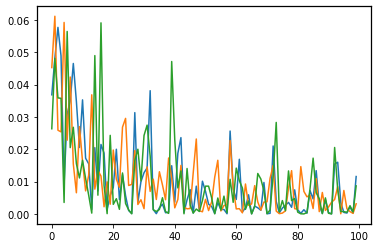

In [28]:
plt.plot(big_cluster_genre_counts/np.sum(big_cluster_genre_counts))
plt.plot(big_cluster2_genre_counts/np.sum(big_cluster2_genre_counts))
plt.plot(big_cluster3_genre_counts/np.sum(big_cluster3_genre_counts))


In [29]:
genre_big3 = np.asarray([big_cluster_genre_counts/np.sum(big_cluster_genre_counts), big_cluster2_genre_counts/np.sum(big_cluster2_genre_counts), big_cluster3_genre_counts/np.sum(big_cluster3_genre_counts)])

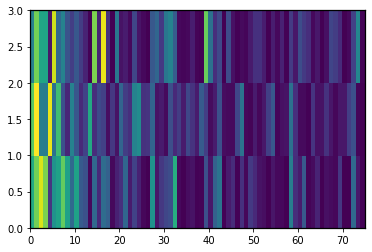

In [30]:
plt.pcolor(genre_big3[:,0:75])

In [31]:
big_cluster_topgenres = np.argsort(-big_cluster_genre_counts)
big_cluster2_topgenres = np.argsort(-big_cluster2_genre_counts)
big_cluster3_topgenres = np.argsort(-big_cluster3_genre_counts)


In [32]:
big_cluster_topgenres

array([ 2,  3,  1,  7, 32,  0, 10,  6,  8, 27,  5, 58, 42, 16, 72,  9, 14,
       21, 17, 41, 11, 61, 93, 12, 92, 39, 31, 86, 30, 23, 99, 49, 29, 69,
        4, 47, 20, 59, 45, 79, 84, 15, 50, 64, 19, 24, 85, 60, 22, 44, 89,
       73, 40, 77, 28, 94, 54, 51, 36, 76, 87, 66, 52, 97, 78, 35, 67, 63,
       75, 18, 56, 55, 13, 33, 82, 80, 68, 25, 48, 62, 38, 95, 43, 90, 37,
       74, 46, 96, 98, 83, 71, 81, 88, 26, 53, 34, 65, 70, 57, 91])

In [33]:
genres.index

Index(['rock', 'seen live', 'indie', 'alternative', 'metal', 'electronic',
       'punk', 'pop', 'indie rock', 'classic rock', 'alternative rock',
       'female vocalists', 'emo', 'death metal', 'Hip-Hop', 'hardcore',
       'electronica', 'singer-songwriter', 'black metal', 'jazz', 'hard rock',
       'folk', 'punk rock', 'Progressive rock', 'heavy metal', 'industrial',
       'metalcore', '80s', 'rap', 'experimental', 'dance', 'ambient',
       'indie pop', 'Progressive metal', 'thrash metal', 'Power metal',
       'post-rock', 'japanese', 'Melodic Death Metal', 'chillout', 'hip hop',
       'british', 'britpop', 'screamo', 'trip-hop', 'new wave', 'Gothic Metal',
       'Grunge', 'ska', 'post-punk', 'blues', 'soul', 'instrumental',
       'doom metal', 'Gothic', 'reggae', 'german', 'finnish', 'favorites',
       'Soundtrack', 'funk', 'acoustic', 'trance', 'Classical', 'psychedelic',
       'folk metal', 'swedish', 'techno', 'idm', 'Canadian', 'J-rock',
       'grindcore', '90s', 'el

In [34]:
genres.index[big_cluster_topgenres][0:5]

Index(['indie', 'alternative', 'seen live', 'pop', 'indie pop'], dtype='object')

In [35]:
genres.index[big_cluster2_topgenres][0:5]

Index(['seen live', 'metal', 'rock', 'punk', 'death metal'], dtype='object')

In [36]:
genres.index[big_cluster3_topgenres][0:5]

Index(['electronica', 'electronic', 'Hip-Hop', 'seen live', 'chillout'], dtype='object')